In [23]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/working/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/working/model_v2.png
/kaggle/working/wandb/debug-internal.log
/kaggle/working/wandb/debug.log
/kaggle/working/wandb/run-20231107_071829-ca2czhvl/run-ca2czhvl.wandb
/kaggle/working/wandb/run-20231107_071829-ca2czhvl/files/requirements.txt
/kaggle/working/wandb/run-20231107_071829-ca2czhvl/files/conda-environment.yaml
/kaggle/working/wandb/run-20231107_071829-ca2czhvl/files/model-best.h5
/kaggle/working/wandb/run-20231107_071829-ca2czhvl/files/config.yaml
/kaggle/working/wandb/run-20231107_071829-ca2czhvl/files/wandb-summary.json
/kaggle/working/wandb/run-20231107_071829-ca2czhvl/files/output.log
/kaggle/working/wandb/run-20231107_071829-ca2czhvl/files/wandb-metadata.json
/kaggle/working/wandb/run-20231107_071829-ca2czhvl/files/media/images/masked_images_56_14f4b2c35e32ab0d39ef.png
/kaggle/working/wandb/run-20231107_071829-ca2czhvl/files/media/images/masks_92_5e45c8486b8f6b048032.png
/kaggle/working/wandb/run-20231107_071829-ca2czhvl/files/media/images/masks_27_ad5226321cf6f34fb3

In [24]:
%%capture
!pip install tensorflow-gpu==2.0

In [25]:
!pip install wandb -q

In [26]:
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras

2.12.0


In [27]:
import wandb
from wandb.keras import WandbCallback

wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [28]:
import os
import cv2
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from mpl_toolkits.axes_grid1 import ImageGrid

In [29]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras
from keras.utils import Sequence
from tensorflow.keras.callbacks import Callback

2.12.0


In [30]:
train_dir = '/kaggle/input/imageinpainting/tiny-imagenet-200/train'
validation_dir = '/kaggle/input/imageinpainting/tiny-imagenet-200/val'
test_dir = '/kaggle/input/imageinpainting/tiny-imagenet-200/test'

In [31]:
class createAugment(keras.utils.Sequence):
  'Generates data for Keras'
  def __init__(self, X, y, batch_size=5, dim=(64, 64), n_channels=3, shuffle=True):
      'Initialization'
      self.batch_size = batch_size
      self.X = X
      self.y = y
      self.dim = dim
      self.n_channels = n_channels
      self.shuffle = shuffle

      self.on_epoch_end()

  def __len__(self):
      'Denotes the number of batches per epoch'
      return int(np.floor(len(self.X) / self.batch_size))

  def __getitem__(self, index):
      'Generate one batch of data'
      # Generate indexes of the batch
      indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

      # Generate data
      X_inputs, y_output = self.__data_generation(indexes)
      return X_inputs, y_output

  def on_epoch_end(self):
      'Updates indexes after each epoch'
      self.indexes = np.arange(len(self.X))
      if self.shuffle:
          np.random.shuffle(self.indexes)

  def __data_generation(self, idxs):
    # Masked_images is a matrix of masked images used as input
    Masked_images = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels)) # Masked image
    # Mask_batch is a matrix of binary masks used as input
    Mask_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels)) # Binary Masks
    # y_batch is a matrix of original images used for computing error from reconstructed image
    y_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels)) # Original image


    ## Iterate through random indexes
    for i, idx in enumerate(idxs):
      image_copy = self.X[idx].copy()

      ## Get mask associated to that image
      masked_image, mask = self.__createMask(image_copy)

      Masked_images[i,] = masked_image/255
      Mask_batch[i,] = mask/255
      y_batch[i] = self.y[idx]/255

    ## Return mask as well because partial convolution require the same.
    return [Masked_images, Mask_batch], y_batch

  def __createMask(self, img):
    ## Prepare masking matrix
    mask = np.full((64,64,3), 255, np.uint8) ## White background
    for _ in range(np.random.randint(1, 10)):
      # Get random x locations to start line
      x1, x2 = np.random.randint(1, 64), np.random.randint(1, 64)
      # Get random y locations to start line
      y1, y2 = np.random.randint(1, 64), np.random.randint(1, 64)
      # Get random thickness of the line drawn
      thickness = np.random.randint(1, 3)
      # Draw black line on the white mask
      cv2.line(mask,(x1,y1),(x2,y2),(0,0,0),thickness)

    ## Mask the image
    masked_image = img.copy()
    masked_image[mask==0] = 255

    return masked_image, mask

In [32]:
train_datagen = ImageDataGenerator(
    rescale=1.0/ 255.0,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen=ImageDataGenerator(rescale=1.0/255.0)

In [33]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(64, 64),  # Adjust the target size as needed
    batch_size=5,           # Adjust the batch size as needed
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(64, 64),  # Adjust the target size as needed
    batch_size=5,           # Adjust the batch size as needed
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(64, 64),  # Adjust the target size as needed
    batch_size=5,           # Adjust the batch size as needed
    class_mode='categorical'
)

Found 100000 images belonging to 200 classes.
Found 10000 images belonging to 1 classes.
Found 10000 images belonging to 1 classes.


In [34]:
import matplotlib.pyplot as plt
for x_batch, y_batch in train_generator:
    x_batch_scaled = (x_batch * 255).astype(np.uint8)
    #y_batch_scaled=(y_batch*255).astype(np.uint8)
    train_gen=createAugment(x_batch_scaled,x_batch_scaled)
    break
for x1_batch,y1_batch in test_generator:
    x1_batch_scaled = (x1_batch * 255).astype(np.uint8)
    test_gen=createAugment(x1_batch_scaled,x1_batch_scaled,shuffle=False)
    break

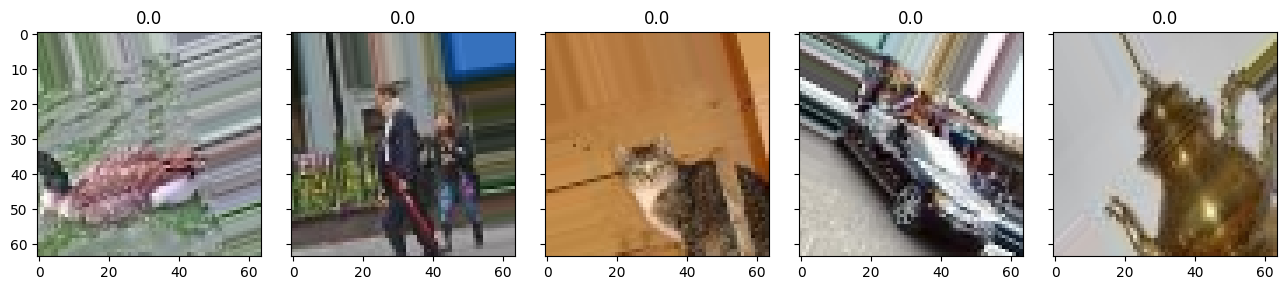

In [35]:
sample_images = x_batch_scaled[:5]
sample_labels = y_batch[:5]

fig = plt.figure(figsize=(16., 8.))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(1, 5),  # creates 2x2 grid of axes
                 axes_pad=0.3,  # pad between axes in inch.
                 )

for ax, image, label in zip(grid, sample_images, sample_labels):
  ax.imshow(image)
  ax.set_title(label[0])

plt.show()

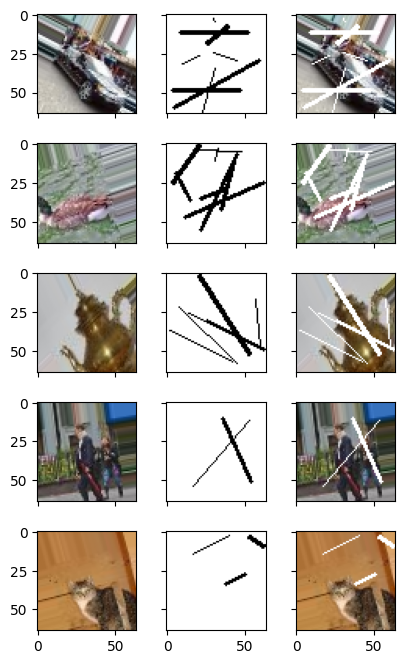

In [36]:
# Legend: Original Image | Mask generated | Masked Image

## Examples
sample_idx =0 ## Change this to see different batches

[masked_images, masks],sample_labels = train_gen[sample_idx]
sample_images = [None]*(len(masked_images)+len(masks)+len(sample_labels))
sample_images[::3] = sample_labels
# masks[]
sample_images[1::3] = masks
sample_images[2::3] = masked_images

fig = plt.figure(figsize=(17., 8.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(5,3),  # creates 2x2 grid of axes
                 axes_pad=0.3,  # pad between axes in inch.
                 )

for ax, image in zip(grid, sample_images):
  ax.imshow(image)

plt.show()

In [37]:
class InpaintingModel:
  '''
  Build UNET like model for image inpaining task.
  '''
  def prepare_model(self, input_size=(64,64,3)):
    input_image = keras.layers.Input(input_size)
    input_mask = keras.layers.Input(input_size, name='encoder_input')

    conv1, mask1, conv2, mask2 = self.__encoder_layer(64, input_image, input_mask, ['conv1', 'conv2'])
    conv3, mask3, conv4, mask4 = self.__encoder_layer(128, conv2, mask2, ['conv3', 'conv4'])
    conv5, mask5, conv6, mask6 = self.__encoder_layer(256, conv4, mask4, ['conv5', 'conv6'])
    conv7, mask7, conv8, mask8 = self.__encoder_layer(512, conv6, mask6, ['conv7', 'encoder_output'])

    conv9, mask9, conv10, mask10 = self.__decoder_layer(512, 256, conv8, mask8, conv7, mask7, ['conv9', 'conv10'])
    conv11, mask11, conv12, mask12 = self.__decoder_layer(256, 128, conv10, mask10, conv5, mask5, ['conv11', 'conv12'])
    conv13, mask13, conv14, mask14 = self.__decoder_layer(128, 64, conv12, mask12, conv3, mask3, ['conv13', 'conv14'])
    conv15, mask15, conv16, mask16 = self.__decoder_layer(64, 3, conv14, mask14, conv1, mask1, ['conv15', 'decoder_output'])

    outputs = keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(conv16)

    return keras.models.Model(inputs=[input_image, input_mask], outputs=[outputs])

  def __encoder_layer(self, filters, in_layer, in_mask, names):
    conv1, mask1 = PConv2D(64, (3,3), strides=1, padding='same', name=names[0])([in_layer, in_mask])
    conv1 = keras.activations.relu(conv1)

    conv2, mask2 = PConv2D(64, (3,3), strides=2, padding='same', name=names[1])([conv1, mask1])
    # conv2 = keras.layers.BatchNormalization()(conv2, training=True)
    conv2 = keras.activations.relu(conv2)

    return conv1, mask1, conv2, mask2

  def __decoder_layer(self, filter1, filter2, in_img, in_mask, share_img, share_mask, names):
    up_img = keras.layers.UpSampling2D(size=(2,2))(in_img)
    up_mask = keras.layers.UpSampling2D(size=(2,2))(in_mask)
    concat_img = keras.layers.Concatenate(axis=3)([share_img, up_img])
    concat_mask = keras.layers.Concatenate(axis=3)([share_mask, up_mask])

    conv1, mask1 = PConv2D(filter1, (3,3), padding='same', name=names[0])([concat_img, concat_mask])
    conv1 = keras.activations.relu(conv1)

    conv2, mask2 = PConv2D(filter2, (3,3), padding='same', name=names[1])([conv1, mask1])
    # conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.activations.relu(conv2)

    return conv1, mask1, conv2, mask2

In [38]:
## Reference: https://github.com/MathiasGruber/PConv-Keras/blob/master/libs/pconv_layer.py
from tensorflow.keras import backend as K
from tensorflow.keras.layers import InputSpec
from tensorflow.keras.layers import Conv2D


class PConv2D(Conv2D):
    def __init__(self, *args, n_channels=3, mono=False, **kwargs):
        super().__init__(*args, **kwargs)
        self.input_spec = [InputSpec(ndim=4), InputSpec(ndim=4)]

    def build(self, input_shape):
        """Adapted from original _Conv() layer of Keras
        param input_shape: list of dimensions for [img, mask]
        """

        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1

        if input_shape[0][channel_axis] is None:
            raise ValueError('The channel dimension of the inputs should be defined. Found `None`.')

        self.input_dim = input_shape[0][channel_axis]

        # Image kernel
        kernel_shape = self.kernel_size + (self.input_dim, self.filters)
        self.kernel = self.add_weight(shape=kernel_shape,
                                      initializer=self.kernel_initializer,
                                      name='img_kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        # Mask kernel
        self.kernel_mask = K.ones(shape=self.kernel_size + (self.input_dim, self.filters))

        # Calculate padding size to achieve zero-padding
        self.pconv_padding = (
            (int((self.kernel_size[0]-1)/2), int((self.kernel_size[0]-1)/2)),
            (int((self.kernel_size[0]-1)/2), int((self.kernel_size[0]-1)/2)),
        )

        # Window size - used for normalization
        self.window_size = self.kernel_size[0] * self.kernel_size[1]

        if self.use_bias:
            self.bias = self.add_weight(shape=(self.filters,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        self.built = True

    def call(self, inputs, mask=None):
        '''
        We will be using the Keras conv2d method, and essentially we have
        to do here is multiply the mask with the input X, before we apply the
        convolutions. For the mask itself, we apply convolutions with all weights
        set to 1.
        Subsequently, we clip mask values to between 0 and 1
        '''

        # Both image and mask must be supplied
        if type(inputs) is not list or len(inputs) != 2:
            raise Exception('PartialConvolution2D must be called on a list of two tensors [img, mask]. Instead got: ' + str(inputs))

        # Padding done explicitly so that padding becomes part of the masked partial convolution
        images = K.spatial_2d_padding(inputs[0], self.pconv_padding, self.data_format)
        masks = K.spatial_2d_padding(inputs[1], self.pconv_padding, self.data_format)

        # Apply convolutions to mask
        mask_output = K.conv2d(
            masks, self.kernel_mask,
            strides=self.strides,
            padding='valid',
            data_format=self.data_format,
            dilation_rate=self.dilation_rate
        )

        # Apply convolutions to image
        img_output = K.conv2d(
            (images*masks), self.kernel,
            strides=self.strides,
            padding='valid',
            data_format=self.data_format,
            dilation_rate=self.dilation_rate
        )

        # Calculate the mask ratio on each pixel in the output mask
        mask_ratio = self.window_size / (mask_output + 1e-8)

        # Clip output to be between 0 and 1
        mask_output = K.clip(mask_output, 0, 1)

        # Remove ratio values where there are holes
        mask_ratio = mask_ratio * mask_output

        # Normalize iamge output
        img_output = img_output * mask_ratio

        # Apply bias only to the image (if chosen to do so)
        if self.use_bias:
            img_output = K.bias_add(
                img_output,
                self.bias,
                data_format=self.data_format)

        # Apply activations on the image
        if self.activation is not None:
            img_output = self.activation(img_output)

        return [img_output, mask_output]

    def compute_output_shape(self, input_shape):
        if self.data_format == 'channels_last':
            space = input_shape[0][1:-1]
            new_space = []
            for i in range(len(space)):
                new_dim = conv_output_length(
                    space[i],
                    self.kernel_size[i],
                    padding='same',
                    stride=self.strides[i],
                    dilation=self.dilation_rate[i])
                new_space.append(new_dim)
            new_shape = (input_shape[0][0],) + tuple(new_space) + (self.filters,)
            return [new_shape, new_shape]
        if self.data_format == 'channels_first':
            space = input_shape[2:]
            new_space = []
            for i in range(len(space)):
                new_dim = conv_output_length(
                    space[i],
                    self.kernel_size[i],
                    padding='same',
                    stride=self.strides[i],
                    dilation=self.dilation_rate[i])
                new_space.append(new_dim)
            new_shape = (input_shape[0], self.filters) + tuple(new_space)
            return [new_shape, new_shape]

## Reference: https://github.com/keras-team/keras/blob/7a39b6c62d43c25472b2c2476bd2a8983ae4f682/keras/utils/conv_utils.py#L85
def conv_output_length(input_length, filter_size,
                       padding, stride, dilation=1):
    """Determines output length of a convolution given input length.
    # Arguments
        input_length: integer.
        filter_size: integer.
        padding: one of `"same"`, `"valid"`, `"full"`.
        stride: integer.
        dilation: dilation rate, integer.
    # Returns
        The output length (integer).
    """
    if input_length is None:
        return None
    assert padding in {'same', 'valid', 'full', 'causal'}
    dilated_filter_size = (filter_size - 1) * dilation + 1
    if padding == 'same':
        output_length = input_length
    elif padding == 'valid':
        output_length = input_length - dilated_filter_size + 1
    elif padding == 'causal':
        output_length = input_length
    elif padding == 'full':
        output_length = input_length + dilated_filter_size - 1
    return (output_length + stride - 1) // stride

In [39]:
## For more information into formulation: https://www.youtube.com/watch?v=AZr64OxshLo
## Metric
def dice_coef(y_true, y_pred):
    y_true_f = keras.backend.flatten(y_true)
    y_pred_f = keras.backend.flatten(y_pred)
    intersection = keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection) / (keras.backend.sum(y_true_f + y_pred_f))

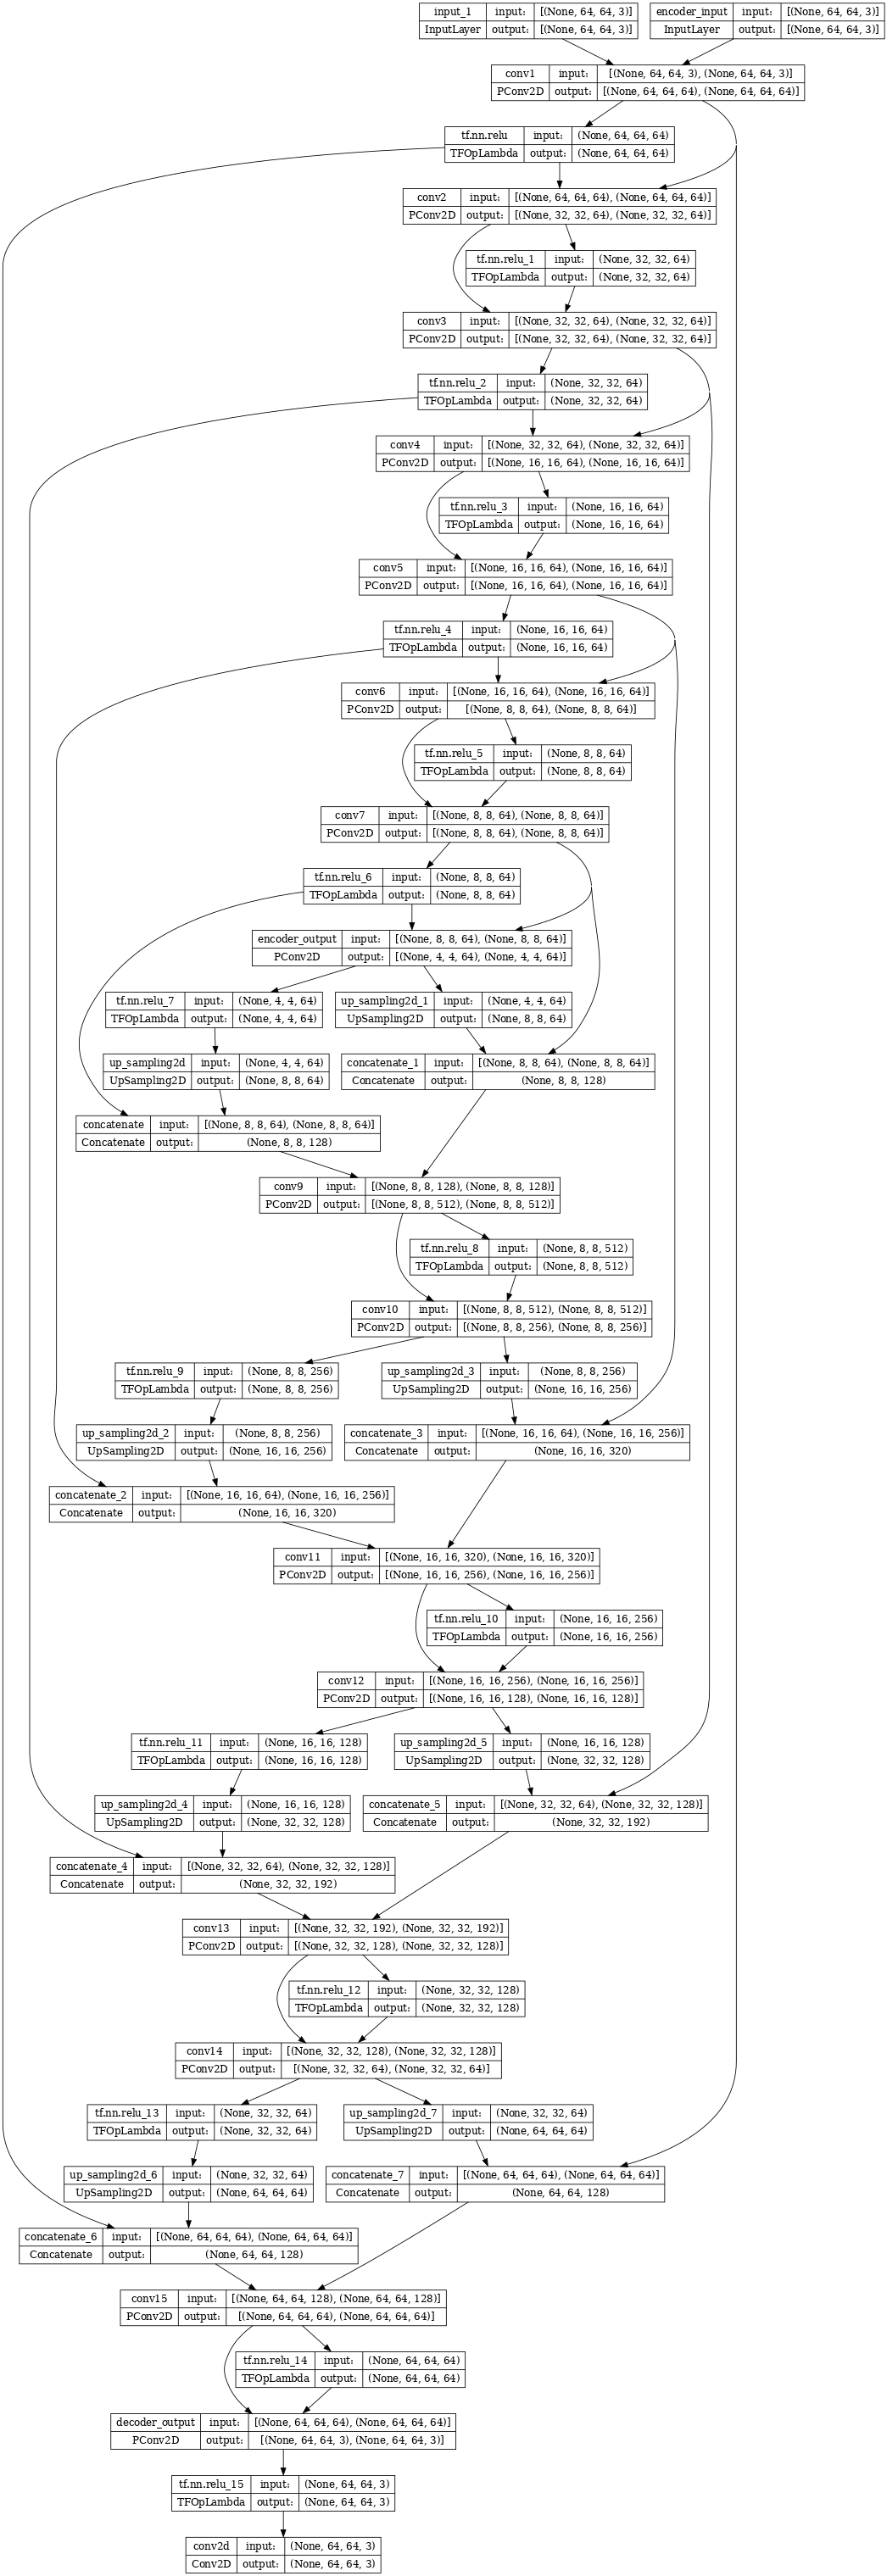

In [40]:
keras.backend.clear_session()
model = InpaintingModel().prepare_model()
# model.summary()
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=[dice_coef])
keras.utils.plot_model(model, show_shapes=True, dpi=60, to_file='model_v2.png')

In [41]:
wandb.init(entity='aditi-dhumal1803', project="ADITI")

dice_coef,▁▇▇████████████████
epoch,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██
loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_dice_coef,▁▃▅▆▅▇▆▆▅▆▆▆▇▆▇██▇▇
val_loss,█▅▃▂▂▂▂▁▂▂▂▂▁▁▁▁▁▁▁
best_epoch,16
best_val_loss,0.01445
dice_coef,0.52012
epoch,18
loss,0.01053
val_dice_coef,0.57389


In [42]:
class PredictionLogger(tf.keras.callbacks.Callback):
    def __init__(self):
        super(PredictionLogger, self).__init__()

    def on_epoch_end(self, logs, epoch):
        sample_idx = 0
        [masked_images, masks], sample_labels = test_gen[sample_idx]

        m_images = []
        binary_masks = []
        predictions = []
        labels = []

        for i in range(5):
          inputs = [masked_images[i].reshape((1,)+masked_images[i].shape), masks[i].reshape((1,)+masks[i].shape)]
          impainted_image = model.predict(inputs)

          m_images.append(masked_images[i])
          binary_masks.append(masks[i])
          predictions.append(impainted_image.reshape(impainted_image.shape[1:]))
          labels.append(sample_labels[i])

        wandb.log({"masked_images": [wandb.Image(m_image)
                              for m_image in m_images]})
        wandb.log({"masks": [wandb.Image(mask)
                              for mask in binary_masks]})
        wandb.log({"predictions": [wandb.Image(inpainted_image)
                              for inpainted_image in predictions]})
        wandb.log({"labels": [wandb.Image(label)
                              for label in labels]})

In [43]:
history= model.fit(x=train_gen, validation_data=test_gen,
          epochs=20,
          steps_per_epoch=1562,
          validation_steps=312,
          use_multiprocessing=True,
          callbacks=[WandbCallback(),
                     PredictionLogger()],
          verbose=2)

Epoch 1/20


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20231107_093214-5ejsi7u8/files/model-best)... Done. 0.4s


1/1 [==============================] - 0s 26ms/step
1562/1562 - 438s - loss: 0.0791 - dice_coef: 0.5484 - val_loss: 0.0678 - val_dice_coef: 0.5609 - 438s/epoch - 280ms/step
Epoch 2/20


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20231107_093214-5ejsi7u8/files/model-best)... Done. 0.3s


1/1 [==============================] - 0s 25ms/step
1562/1562 - 428s - loss: 0.0228 - dice_coef: 0.5813 - val_loss: 0.0429 - val_dice_coef: 0.5725 - 428s/epoch - 274ms/step
Epoch 3/20


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20231107_093214-5ejsi7u8/files/model-best)... Done. 0.3s


1/1 [==============================] - 0s 29ms/step
1562/1562 - 433s - loss: 0.0160 - dice_coef: 0.5832 - val_loss: 0.0359 - val_dice_coef: 0.5784 - 433s/epoch - 277ms/step
Epoch 4/20


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20231107_093214-5ejsi7u8/files/model-best)... Done. 0.3s


1/1 [==============================] - 0s 26ms/step
1562/1562 - 434s - loss: 0.0144 - dice_coef: 0.5839 - val_loss: 0.0341 - val_dice_coef: 0.5799 - 434s/epoch - 278ms/step
Epoch 5/20


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20231107_093214-5ejsi7u8/files/model-best)... Done. 0.3s


1/1 [==============================] - 0s 25ms/step
1562/1562 - 432s - loss: 0.0132 - dice_coef: 0.5843 - val_loss: 0.0296 - val_dice_coef: 0.5833 - 432s/epoch - 277ms/step
Epoch 6/20


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20231107_093214-5ejsi7u8/files/model-best)... Done. 0.3s


1/1 [==============================] - 0s 27ms/step
1562/1562 - 434s - loss: 0.0123 - dice_coef: 0.5847 - val_loss: 0.0277 - val_dice_coef: 0.5834 - 434s/epoch - 278ms/step
Epoch 7/20


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20231107_093214-5ejsi7u8/files/model-best)... Done. 0.3s


1/1 [==============================] - 0s 25ms/step
1562/1562 - 429s - loss: 0.0118 - dice_coef: 0.5849 - val_loss: 0.0259 - val_dice_coef: 0.5844 - 429s/epoch - 275ms/step
Epoch 8/20
1/1 [==============================] - 0s 26ms/step
1562/1562 - 427s - loss: 0.0114 - dice_coef: 0.5851 - val_loss: 0.0289 - val_dice_coef: 0.5832 - 427s/epoch - 273ms/step
Epoch 9/20


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20231107_093214-5ejsi7u8/files/model-best)... Done. 0.3s


1/1 [==============================] - 0s 37ms/step
1562/1562 - 436s - loss: 0.0112 - dice_coef: 0.5852 - val_loss: 0.0254 - val_dice_coef: 0.5847 - 436s/epoch - 279ms/step
Epoch 10/20
1/1 [==============================] - 0s 25ms/step
1562/1562 - 425s - loss: 0.0108 - dice_coef: 0.5854 - val_loss: 0.0260 - val_dice_coef: 0.5850 - 425s/epoch - 272ms/step
Epoch 11/20


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20231107_093214-5ejsi7u8/files/model-best)... Done. 0.3s


1/1 [==============================] - 0s 24ms/step
1562/1562 - 430s - loss: 0.0105 - dice_coef: 0.5855 - val_loss: 0.0244 - val_dice_coef: 0.5857 - 430s/epoch - 275ms/step
Epoch 12/20
1/1 [==============================] - 0s 26ms/step
1562/1562 - 427s - loss: 0.0104 - dice_coef: 0.5855 - val_loss: 0.0257 - val_dice_coef: 0.5858 - 427s/epoch - 273ms/step
Epoch 13/20


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20231107_093214-5ejsi7u8/files/model-best)... Done. 0.3s


1/1 [==============================] - 0s 23ms/step
1562/1562 - 433s - loss: 0.0102 - dice_coef: 0.5856 - val_loss: 0.0232 - val_dice_coef: 0.5870 - 433s/epoch - 277ms/step
Epoch 14/20
1/1 [==============================] - 0s 29ms/step
1562/1562 - 427s - loss: 0.0100 - dice_coef: 0.5857 - val_loss: 0.0238 - val_dice_coef: 0.5868 - 427s/epoch - 273ms/step
Epoch 15/20
1/1 [==============================] - 0s 29ms/step
1562/1562 - 429s - loss: 0.0101 - dice_coef: 0.5857 - val_loss: 0.0235 - val_dice_coef: 0.5872 - 429s/epoch - 275ms/step
Epoch 16/20


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20231107_093214-5ejsi7u8/files/model-best)... Done. 0.3s


1/1 [==============================] - 0s 25ms/step
1562/1562 - 433s - loss: 0.0100 - dice_coef: 0.5858 - val_loss: 0.0197 - val_dice_coef: 0.5889 - 433s/epoch - 277ms/step
Epoch 17/20
1/1 [==============================] - 0s 25ms/step
1562/1562 - 427s - loss: 0.0097 - dice_coef: 0.5859 - val_loss: 0.0245 - val_dice_coef: 0.5860 - 427s/epoch - 273ms/step
Epoch 18/20
1/1 [==============================] - 0s 25ms/step
1562/1562 - 428s - loss: 0.0097 - dice_coef: 0.5859 - val_loss: 0.0224 - val_dice_coef: 0.5874 - 428s/epoch - 274ms/step
Epoch 19/20
1/1 [==============================] - 0s 25ms/step
1562/1562 - 428s - loss: 0.0095 - dice_coef: 0.5859 - val_loss: 0.0219 - val_dice_coef: 0.5880 - 428s/epoch - 274ms/step
Epoch 20/20
1/1 [==============================] - 0s 24ms/step
1562/1562 - 426s - loss: 0.0094 - dice_coef: 0.5860 - val_loss: 0.0200 - val_dice_coef: 0.5889 - 426s/epoch - 272ms/step


In [50]:
model.save('trainedmodel.h5')

1/1 [==============================] - 0s 39ms/step


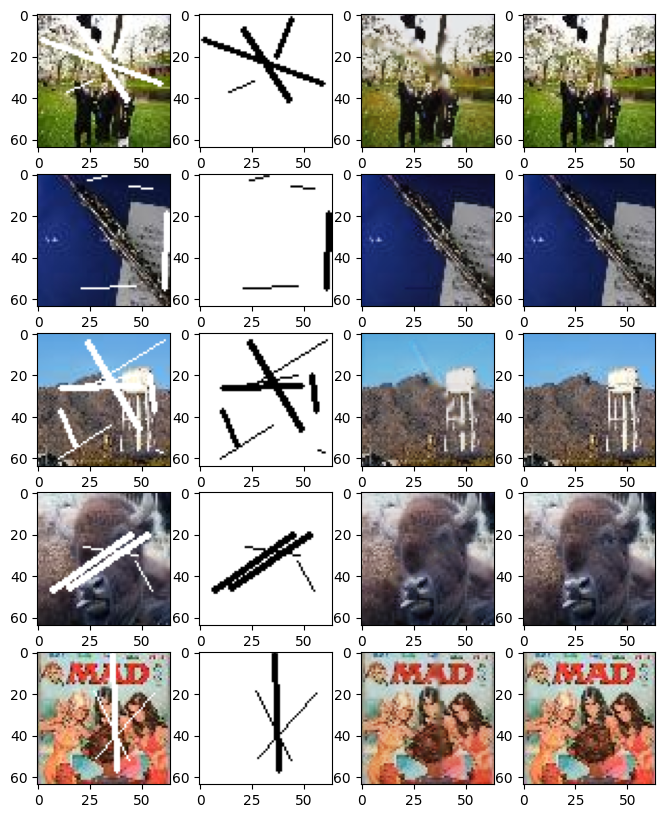

In [44]:
rows = 5
sample_idx = 0
[masked_images, masks], sample_labels = test_gen[sample_idx]


fig, axs = plt.subplots(nrows=rows, ncols=4, figsize=(8, 2*rows))

for i in range(5):
  inputs = [masked_images[i].reshape((1,)+masked_images[i].shape), masks[i].reshape((1,)+masks[i].shape)]
  impainted_image = model.predict(inputs)
  axs[i][0].imshow(masked_images[i])
  axs[i][1].imshow(masks[i])
  axs[i][2].imshow(impainted_image.reshape(impainted_image.shape[1:]))
  axs[i][3].imshow(sample_labels[i])

1/1 [==============================] - 0s 26ms/step


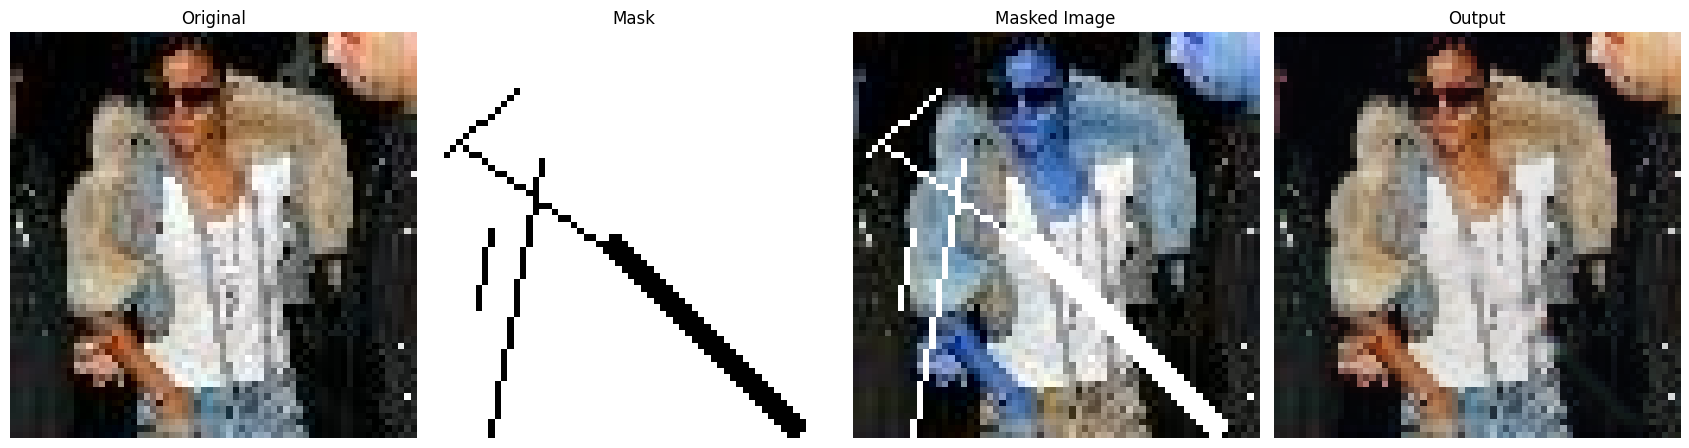

In [45]:
import cv2
import numpy as np
from keras.models import load_model
import matplotlib.pyplot as plt


image_path = '/kaggle/input/imageinpainting/tiny-imagenet-200/test/images/test_1004.JPEG'
original_image = cv2.imread(image_path)
resized_image = cv2.resize(original_image, (64, 64))
normalized_image = resized_image / 255.0 

def createMask(img):
    
    mask = np.full((64,64,3), 1, np.float32) 
    for _ in range(np.random.randint(1, 10)):
      x1, x2 = np.random.randint(1, 64), np.random.randint(1, 64)
      y1, y2 = np.random.randint(1, 64), np.random.randint(1, 64)
      thickness = np.random.randint(1, 3)
      cv2.line(mask,(x1,y1),(x2,y2),(0,0,0),thickness)

    masked_image = img.copy()
    masked_image[mask==0] = 1

    return masked_image, mask

input_image, input_mask = createMask(normalized_image)
input_image = np.expand_dims(input_image, axis=0)
input_mask = np.expand_dims(input_mask, axis=0)
predicted_image = model.predict([input_image, input_mask])
output_image = predicted_image.squeeze()  
output_image = (output_image * 255).astype(np.uint8)
plt.figure(figsize=(17, 8))
plt.subplot(1, 4, 1)
plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
plt.title("Original")
plt.axis('off')
plt.subplot(1, 4, 2)
plt.imshow(input_mask.squeeze(), cmap='gray')  
plt.title("Mask")
plt.axis('off')
plt.subplot(1, 4, 3)
plt.imshow((input_image.squeeze() * 255).astype(np.uint8))
plt.title("Masked Image")
plt.axis('off')
plt.subplot(1, 4, 4)
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.title("Output")
plt.axis('off')
plt.tight_layout()
plt.show()